# Libs

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from itertools import product
from time import time

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'time', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Upload data

In [27]:
train_data = pd.read_csv('../input/bioresponse/train.csv', header=0, sep=',')
test_data = pd.read_csv('../input/bioresponse/test.csv')
print(f"Train data has {train_data.shape[0]} rows and {train_data.shape[1]} columns.")

Train data has 3751 rows and 1777 columns.


In [28]:
print("Example of the table:")
train_data.head()

Example of the table:


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [29]:
bioresponce_target = train_data.Activity.values
print(f"Target value is binary. Clasess have these proportions:")
print('bioresponse = 1: {:.2f}\nbioresponse = 0: {:.2f}'.format(sum(bioresponce_target)/float(len(bioresponce_target)), 
                1.0 - sum(bioresponce_target)/float(len(bioresponce_target))))

Target value is binary. Clasess have these proportions:
bioresponse = 1: 0.54
bioresponse = 0: 0.46


In [30]:
train = train_data.iloc[:,1:]
test = test_data.iloc[:,:]

print('Train sample is splitted on train and control samples. Control sample will never be learned by a model.')
X_train, X_control, y_train, y_control = train_test_split(train, bioresponce_target, test_size = 0.25, random_state = 100, stratify = bioresponce_target)
print(f'Size of train sample is {len(X_train)} rows.\nSize of control sample is {len(X_control)} rows')
print('Train and control samples are stratified:')
print(f'Proportion of 1 class is {sum(y_train)/float(len(y_train)):.2f} in train sample.')
print(f'Proportion of 1 class is {sum(y_control)/float(len(y_control)):.2f} in control sample.')

Train sample is splitted on train and control samples. Control sample will never be learned by a model.
Size of train sample is 2813 rows.
Size of control sample is 938 rows
Train and control samples are stratified:
Proportion of 1 class is 0.54 in train sample.
Proportion of 1 class is 0.54 in control sample.


# Decision Tree

[Decision Trees](https://scikit-learn.org/stable/modules/tree.html#tree) (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

For scoring [log_loss](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss) function  is used. Less is better.

In [31]:
from sklearn import tree

print ("Build tree with different parameters of quality of split and strategy used to choose the split ...")
criterions = ['gini', 'entropy']
splitters = ['best', 'random']
parameters = product(criterions, splitters)
parameters_list = list(parameters)
for c, s in parameters_list:
    t0 = time()
    dt = tree.DecisionTreeClassifier(criterion=c, splitter=s, max_depth=None, random_state=100)
    scores  = cross_val_score(dt, X_train, y_train, cv=10, scoring = 'neg_log_loss')
    t1 = time()
    print(f"[{t1-t0:.2f} sec] : Log-loss score for [{c}, {s}] is: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))
print("Tree with cross-entropy split criterion is better for this sample.")

Build tree with different parameters of quality of split and strategy used to choose the split ...
[10.65 sec] : Log-loss score for [gini, best] is: 9.66 (+/- 1.87)
[6.10 sec] : Log-loss score for [gini, random] is: 10.47 (+/- 1.92)
[9.88 sec] : Log-loss score for [entropy, best] is: 9.55 (+/- 2.14)
[5.36 sec] : Log-loss score for [entropy, random] is: 9.87 (+/- 1.45)
Tree with cross-entropy split criterion is better for this sample.


In [32]:
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, random_state=100)
print(f"Check the model on control set...")
dt = dt.fit(X_train, y_train)
predictions = dt.predict_proba(X_control)
print(f"Scoring for control set is {log_loss(y_control, predictions[:, 1]):.2f}")
print(f"The score is huge (proximity to 0 is better for log-loss). ")

Check the model on control set...
Scoring for control set is 9.46
The score is huge (proximity to 0 is better for log-loss). 


# Bootstrap/Bagging

In ensemble algorithms, [bagging](https://scikit-learn.org/stable/modules/ensemble.html#bagging) methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction.

Usually, when samples are drawn with replacement, then the method is known as Bagging

Composition for classification:
$$a(x)=sign\frac{1}{N}\sum_{n=1}^{N}b_n(x)$$

Parameters:
- `bootstrap` : Whether samples are drawn with replacement. If False, sampling
    without replacement is performed.
- `max_features` : The number of features to draw from X to train each base estimator.

For *Bagging* max_features = 1.0 is used. In less value the method is known as *Random Subspaces*.

In [ ]:
%%time

from sklearn.ensemble import BaggingClassifier

# define number pf features
d = X_train.shape[1]

# define explicitly
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, random_state=100)
# bagging on tree classifier
bagging = BaggingClassifier(base_estimator=dt, n_estimators = 5, 
                                 bootstrap = True, n_jobs = -1, random_state=100, max_features=d)
# objects in samples are different
no_bootstrap = BaggingClassifier(base_estimator=dt, n_estimators = 5, 
                                    bootstrap = False, n_jobs = -1, random_state=100, max_features=d)

# recommended number of features for bagging is d**0.5 (Random Subspaces)
random_subspaces = BaggingClassifier(base_estimator=dt, n_estimators = 5, 
                                 bootstrap = True, n_jobs = -1, random_state=100, max_features=int(d**0.5))

# parameter to check classifier's score
number_of_trees = np.linspace(0, 100, 11, dtype = int); number_of_trees[0]=1

bagging_result = []
no_bootstrap_result = []
random_subspaces_result = []
for result, cls in zip([bagging_result, no_bootstrap_result, random_subspaces_result], 
                       [bagging, no_bootstrap, random_subspaces]):
    for n in number_of_trees:
        cls.set_params(**{'n_estimators': n})
        scores = cross_val_score(cls, X_train, y_train, cv=3, scoring = 'neg_log_loss')
        result.append(-scores.mean())

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize = (18, 6))
plt.grid(True)
plt.plot(number_of_trees, bagging_result, c = 'green', marker='o', label='bagging')
plt.plot(number_of_trees, no_bootstrap_result, c = 'red', label='no bootstrap')
plt.plot(number_of_trees, random_subspaces_result, c = 'blue', label='random subspaces')
plt.title("Log-loss score by number of trees.")
plt.legend(loc='upper right');
print(f'Best result is {min(bagging_result):.2f} on {number_of_trees[np.argmin(bagging_result)]} trees.')

# Random Forest

A [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset. Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size.

The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

Look [Bias-Variance trade-off](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) .

In [34]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_results = []
manual_rf_results = []
random_subspaces_result = []
rfc = RandomForestClassifier(n_estimators = 5, random_state=100, criterion='entropy', 
                             n_jobs = -1, max_depth=None,  max_features = 'sqrt')
# manual version of RandomForest
manual_rfc = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion='entropy', 
                                                                          splitter='best', 
                                                                          max_depth=None, 
                                                                          random_state=100,
                                                                          max_features = int(d**0.5)), # random subspace
                               n_estimators = 5, bootstrap = True, n_jobs = -1, random_state=100)

# recommended number of features for bagging is d**0.5 (Random Subspaces)
random_subspaces = BaggingClassifier(base_estimator=dt, n_estimators = 5, 
                                 bootstrap = True, n_jobs = -1, random_state=100, max_features=int(d**0.5))

number_of_trees = np.linspace(50, 500, 10, dtype = int)

for result, cls in zip([rf_results, manual_rf_results, random_subspaces_result], [rfc, manual_rfc, random_subspaces]):
    for n in number_of_trees:
        cls.set_params(**{'n_estimators': n})
        scores = cross_val_score(cls, X_train, y_train, cv=3, scoring = 'neg_log_loss', n_jobs = -1)
        result.append(-scores.mean())

CPU times: user 46.3 s, sys: 5.41 s, total: 51.7 s
Wall time: 4min 14s


Best result is 0.48 on 500 trees.


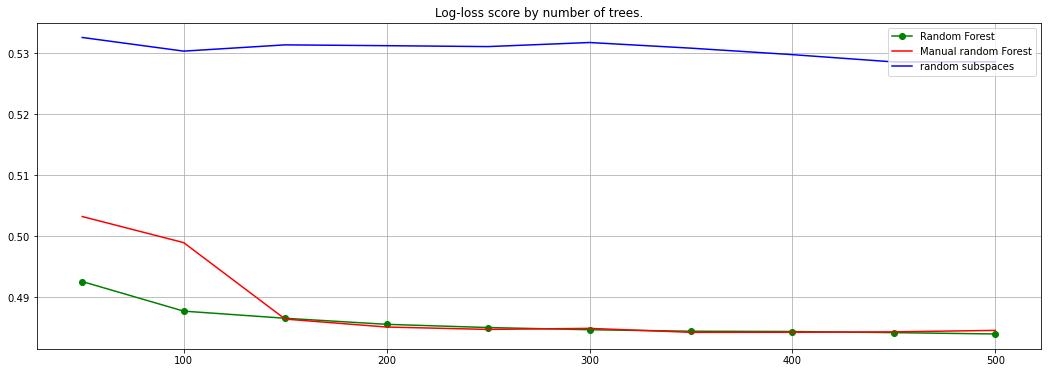

In [44]:
plt.figure(figsize = (18, 6))
plt.grid(True)
plt.plot(number_of_trees, rf_results, c = 'green', marker='o', label='Random Forest')
plt.plot(number_of_trees, manual_rf_results, c = 'red', label='Manual random Forest')
plt.plot(number_of_trees, random_subspaces_result, c = 'blue', label='random subspaces')
plt.title("Log-loss score by number of trees.")
plt.legend(loc='upper right');
print(f'Best result is {min(rf_results):.2f} on {number_of_trees[np.argmin(rf_results)]} trees.')

Explore how evaluate Random Forest with different number of features:

In [82]:
%%time
nfs = np.linspace(1, 150, 150, dtype = int)
rfc = RandomForestClassifier(n_estimators = 500, max_features = 100, 
                                 random_state=100, criterion='entropy',
                                 n_jobs = -1, max_depth=None,)
score_results = []
for n in tqdm(nfs):
    rfc.set_params(**{'max_features': n})
    scores = cross_val_score(estimator =rfc, X = X_train, y = y_train, cv = 3, scoring = 'neg_log_loss', n_jobs=-1)
    score_results.append(-scores.mean())

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



CPU times: user 3.46 s, sys: 2.21 s, total: 5.66 s
Wall time: 18min


Big number of featuers (closer to full number of dimensions) does not give good results. Less features -> bootstraped samples are more different.


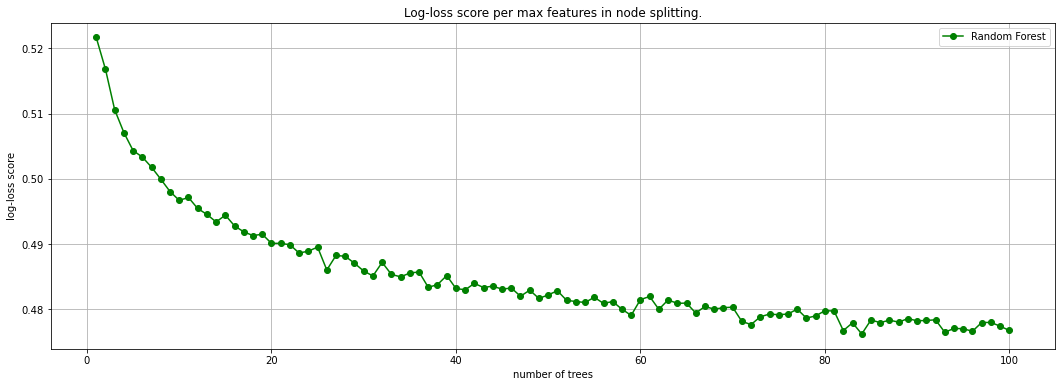

In [88]:
print('Big number of featuers (closer to full number of dimensions) does not give good results. Less features -> bootstraped samples are more different.')
plt.figure(figsize = (18, 6))
plt.grid(True)
plt.plot(nfs, score_results, c = 'green', marker='o', label='Random Forest')
plt.title("Log-loss score per max features in node splitting.")
plt.ylabel("log-loss score")
plt.xlabel("number of trees")
plt.legend(loc='upper right');

# Gradient Boosting

[Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

Elements of trees composition are defined:

$$b_N(x)=argmin_b\frac{1}{l}\sum_{i=1}^{l}(b(x_i)-(y_i-\sum_{n=1}^{N-1}b_n(x_i)))^2$$

GB composition:
$$a_N(x)=\sum_{n=1}^{N}b_n(x)$$

loss function is log-loss for classification.

In [90]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

print("Gradient boosting uses weak base estimators in nature. In this example max_depth in tree equals 1 ...")
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05, 
                                 max_depth=1, random_state=100)

scores  = cross_val_score(gbc, X_train, y_train, cv=3, scoring = 'neg_log_loss')
print(f"Log-loss score on cross-validation is: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))
print("It's good result with no large calculation time consumption as in Random Forest.")

Gradient boosting uses weak base estimators in nature. In this example max_depth in tree equals 1 ...
Log-loss score on cross-validation is: 0.51 (+/- 0.04)
It's good result with no large calculation time consumption as in Random Forest.
CPU times: user 1min 48s, sys: 0 ns, total: 1min 48s
Wall time: 1min 48s


In [91]:
print(f"Check the model on control set...")
gbc = gbc.fit(X_train, y_train)
predictions = gbc.predict_proba(X_control)
print(f"Scoring for control set is {log_loss(y_control, predictions[:, 1]):.2f}")

Check the model on control set...
Scoring for control set is 0.49


In [148]:
step = 100
MIN, MAX = 100, 3000
number_of_trees = np.linspace(MIN, MAX, int((MAX-MIN)/step)+1, dtype = int)

params = [{'max_depth': x} for x in range(1,4)]
results = [[] for _ in params]

for result, param in tqdm(zip(results, params), total = len(results)):
    cls = GradientBoostingClassifier(n_estimators=1, learning_rate=0.05, 
                                 max_depth=1, random_state=100)
    cls.set_params(**param)
    for n in tqdm(number_of_trees):
        cls.set_params(n_estimators=n)
        scores = cross_val_score(cls, X_train, y_train, cv=3, scoring = 'neg_log_loss', n_jobs = -1)
        result.append(-scores.mean())

KeyboardInterrupt: 

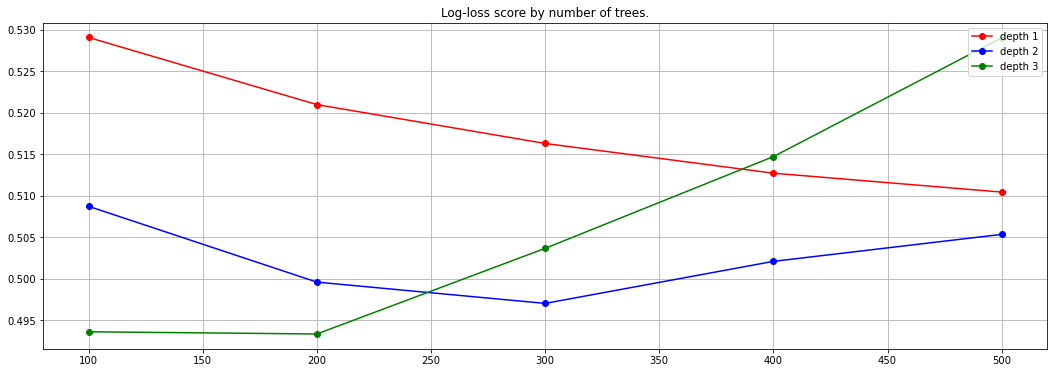

In [145]:
plt.figure(figsize = (18, 6))
plt.grid(True)
for result, color, text in zip(results,
                               ['red', 'blue', 'green'], 
                               ['depth 1', 'depth 2', 'depth 3']):
    plt.plot(number_of_trees[:len(result)], result, c = color, marker='o', label=text)
plt.title("Log-loss score by number of trees.")
plt.legend(loc='upper right');
# print(f'Best result is {min(rf_results):.2f} on {number_of_trees[np.argmin(rf_results)]} trees.')

In [63]:
# XgBoost

In [64]:
# LightGBM